# Problem Parameters

In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
k_a = 1  # Fitness gain factor
k_f = 2  # Fatigue accumulation factor
tau_a = 45  # Fitness decay constant
tau_f = 12   # Fatigue recovery constant
eta = 0.1   # Sensitivity of performance to fatigue ? Not exactly sure what this number should be yet or if I need it
T = 170    # Time from beginning of training to Ivy League Championships (peak)
p_desired = 1.5  # Arbitrary number, need to scale and determine if you want a percent increase or actual time

# Discretize the state space and time horizon

In [2]:
# State and time grid
n_g, n_h, n_t = 50, 50, 170  # Number of grid points for g, h, and t
g_max, h_max = 2.0, 1.5  # Guess max fitness and fatigue ? need to look in literature
g_grid = np.linspace(0, g_max, n_g)
h_grid = np.linspace(0, h_max, n_h)
t_grid = np.linspace(0, T, n_t)

# Value function and optimal w storage
V = np.full((n_g, n_h, n_t), np.inf)  # Initialize V with large values
W_opt = np.zeros((n_g, n_h, n_t))  # To store optimal w(t)

# Terminal condition for V at t = T
for i in range(n_g):
    for j in range(n_h):
        g, h = g_grid[i], h_grid[j]
        p = g * np.exp(-eta * h) # or g - h
        V[i, j, -1] = p - p_desired

# Solve $V(g,h,t)$ and $w_{opt}(t)$ backward in time

In [3]:
# Time step size
dt = T / (n_t - 1)
dg = g_grid[1] - g_grid[0]
dh = h_grid[1] - h_grid[0]

# Backward HJB solver
for t_idx in range(n_t - 2, -1, -1):  # Start from second-to-last time step
    for i in range(1, n_g):  # Skip g_min for backward difference
        for j in range(1, n_h):  # Skip h_min for backward difference
            # Gradients of V
            dV_dg = (V[i, j, t_idx+1] - V[i-1, j, t_idx+1]) / dg
            dV_dh = (V[i, j, t_idx+1] - V[i, j-1, t_idx+1]) / dh
            grad_V = np.array([dV_dg, dV_dh])

            # Hamiltonian components
            def F1(w): return k_a * h_grid[j] * (1 - w) - g_grid[i] / tau_a
            def F2(w): return k_f * w - h_grid[j] / tau_f

            # Maximize H to find optimal w
            w_opt = max(0, min(1, (grad_V[1] * k_f - grad_V[0] * k_a * h_grid[j]) / 2))
            W_opt[i, j, t_idx] = w_opt  # Store optimal w

            # Compute the dynamics using w_opt
            F = np.array([F1(w_opt), F2(w_opt)])
            C = w_opt**2  # Quadratic cost of training load

            # Update value function
            V[i, j, t_idx] = V[i, j, t_idx+1] - dt * (grad_V @ F - C)

/var/folders/ws/vy5jrlkn4kv171774n_ry5hh0000gn/T/ipykernel_12483/1071430336.py:20: RuntimeWarning: invalid value encountered in scalar subtract
  w_opt = max(0, min(1, (grad_V[1] * k_f - grad_V[0] * k_a * h_grid[j]) / 2))
/var/folders/ws/vy5jrlkn4kv171774n_ry5hh0000gn/T/ipykernel_12483/1071430336.py:28: RuntimeWarning: invalid value encountered in matmul
  V[i, j, t_idx] = V[i, j, t_idx+1] - dt * (grad_V @ F - C)
/var/folders/ws/vy5jrlkn4kv171774n_ry5hh0000gn/T/ipykernel_12483/1071430336.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  dV_dh = (V[i, j, t_idx+1] - V[i, j-1, t_idx+1]) / dh
/var/folders/ws/vy5jrlkn4kv171774n_ry5hh0000gn/T/ipykernel_12483/1071430336.py:11: RuntimeWarning: invalid value encountered in scalar subtract
  dV_dg = (V[i, j, t_idx+1] - V[i-1, j, t_idx+1]) / dg


# Interpolate
The interpolation function takes any $g,h,t$ as input and returns the corresponding $w_{opt}(g,h,t)$ by interpolating between the grid points.

In [4]:
# Interpolator for w_opt
interpolate_w_opt = RegularGridInterpolator((g_grid, h_grid, t_grid), W_opt, bounds_error=False, fill_value=0)

# Simulate $g(t)$, $h(t)$, and $p(t)$ forward in time starting from initial conditions

In [5]:
# Forward simulation of dynamics
def forward_dynamics(t, y):
    g, h = y
    w_t = interpolate_w_opt((g, h, t))  # Get optimal w(t) from interpolator
    dg_dt = k_a * h * (1 - w_t) - g / tau_a
    dh_dt = k_f * w_t - h / tau_f
    return [dg_dt, dh_dt]

# Initial conditions
g0, h0 = 1.0, 0.5  # Arbitrary starting fitness and fatigue
y0 = [g0, h0]

# Time points for forward simulation
t_eval = np.linspace(0, T, 1000)

# Solve forward dynamics
solution = solve_ivp(forward_dynamics, (0, T), y0, t_eval=t_eval)
time = solution.t
g = solution.y[0]
h = solution.y[1]

# Compute performance
p = g * np.exp(-eta * h)   # Option 1
p = g - h    # Option 2

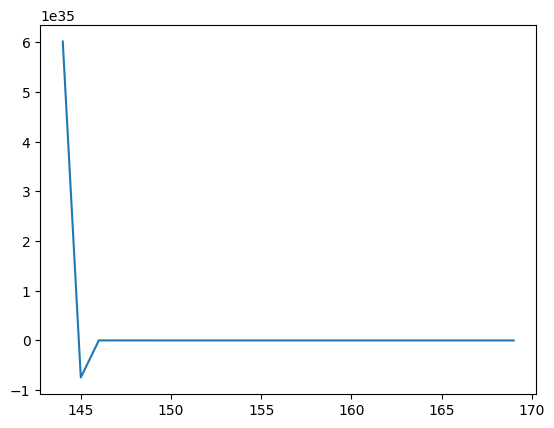

In [8]:
import matplotlib.pyplot as plt
plt.plot(V[25, 25, :])